# Notebook to showcase analysis of US earners on the threshold of 50k USD - from census data (1994-95)
by Rafal Rakowski May 2021

### Task in question:
#### Explore census dataset and build a binary classification model that predicts income level for a given record.

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
# prepare compute environment
import numpy as np # linear algebra
import pandas as pd # data processing
from pandas import Series, DataFrame
import matplotlib.pyplot as plt # data visualization 
import seaborn as sns # statistical data visualization
import scipy as sc # some maths functions
from scipy.stats import spearmanr # Spearman correlation
import sklearn # data modelling
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # models
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # grid search
import category_encoders as ce # encoding
from sklearn.preprocessing import RobustScaler # variables scaling
from sklearn.metrics import accuracy_score # model metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score # ROC AUC
from sklearn.model_selection import cross_val_score # cross_val ROC AUC
from tqdm import tqdm
%matplotlib inline

In [9]:
%pwd

'/Users/Raf/Dataiku_practical'

## 1. Explanatory Data Analysis

In [17]:
# read-in census data into Pandas
train_data = '/Users/Raf/Dataiku_practical/census_income_learn.csv'
test_data = '/Users/Raf/Dataiku_practical/census_income_test.csv'
column_names = ['age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode', 
                'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_stat', 
                'major_industry_code',  'major_occupation_code', 'race', 'hispanic_origin', 'sex',
                'member_of_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat',
                'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat', 
                'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat',
                'detailed_household_summary_in_household', 'instance_weight', 'migration_code_change_in_msa', 
                'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
                'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 
                'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 
                'own_business_or_self_employed', 'fill_inc_questionnaire_for_veteran', 
                'veterans_benefits', 'weeks_worked_in_year', 'year', 'salary']
# data for modelling
df_train = pd.read_csv(train_data, header=None, names=column_names)
df_test = pd.read_csv(test_data, header=None, names=column_names)
# data for explonatory analysis
df_analysis = pd.concat([df_train, df_test])
df_analysis.loc[df_analysis['salary'].astype(str) == ' 50000+.', 'Income'] = '> $50k'
df_analysis.loc[df_analysis['salary'].astype(str) == ' - 50000.', 'Income'] = '< $50k'
df_train.drop(columns=['instance_weight'], inplace=True)
df_test.drop(columns=['instance_weight'], inplace=True)

In [8]:
# print no. of observations and features for modeling data after removing column related to sample's stratified estimates
print('Number of (records, features) for test set:')
print(df_test.shape)
print()
print('Number of (records, features) for training set:')
print(df_train.shape)

Number of (records, features) for test set:
(99762, 41)

Number of (records, features) for training set:
(199523, 41)


In [ ]:
### 1a) Tabular Representation of Data

In [15]:
# first glance at training dataframe structure
df_train

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran,veterans_benefits,weeks_worked_in_year,year,salary
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
199520,47,Not in universe,0,0,Some college but no degree,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Poland,Poland,Germany,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,95,- 50000.
199521,16,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.


In [11]:
# check for duplicated input observations
print('Number of replicated records:')
df_analysis[df_analysis.duplicated()].shape

Number of replicated records:


(6735, 43)

In [97]:
# check for target labels balance
print('Train set class balance:\n', df_train['salary'].value_counts())
print('Test set class balance:\n', df_test['salary'].value_counts())
temp = pd.DataFrame(df_analysis['salary'].value_counts())
imbalance_ratio =  temp.iloc[0,0] / float(temp.iloc[1,0])

print('Imbalance ratio: 1 earning over $50k per {0:.1f} earning less (for whole dataset)'.format(imbalance_ratio)) 

Train set class balance:
  - 50000.    187141
 50000+.      12382
Name: salary, dtype: int64
Test set class balance:
  - 50000.    93576
 50000+.      6186
Name: salary, dtype: int64
Imbalance ratio: 1 earning over $50k per 15.1 earning less (for whole dataset)


<span style='color:blue'>
    Comment:
    
- Highly imbalance binary target variable with 15 to 1 ratio (low {<$50} to  high {>$50k} income) over total dataset.
</span> 

In [13]:
# project number of high & low earners onto entire US population
df_analysis_US = df_analysis[['instance_weight', 'Income']]

print('Income levels projected on entire US population:\n\n' ,df_analysis_US.groupby('Income').agg('sum'))
df_analysis_US = df_analysis_US.groupby('Income')

print('\nAnd after dropping duplicate records:\n')
populations = df_analysis_US.agg(lambda x: x.drop_duplicates('instance_weight', keep='first').instance_weight.sum())

print(populations)
populations['total'] = populations['instance_weight'].sum()  
population_poor = populations.iloc[0,0]
population_rich = populations.iloc[1,0]
population_all = populations.iloc[1,1]
percentage = population_rich / population_poor

# show percent of the earners above >$50k
print('\nPercentage of high(>$50k) to low(<$50k) earning folks: {0:0.2%}'.format(percentage))

Income levels projected on entire US population:

         instance_weight
Income                 
< $50k     4.875434e+08
> $50k     3.324277e+07

And after dropping duplicate records:

        instance_weight
Income                 
< $50k     2.266081e+08
> $50k     2.305890e+07

Percentage of high(>$50k) to low(<$50k) earning folks: 10.18%


<span style='color:blue '>
Observation:

-  Above $50k earners make up ~ 10% of the US population.
</span>

In [14]:
# peek at training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   age                                      199523 non-null  int64 
 1   class_of_worker                          199523 non-null  object
 2   detailed_industry_recode                 199523 non-null  int64 
 3   detailed_occupation_recode               199523 non-null  int64 
 4   education                                199523 non-null  object
 5   wage_per_hour                            199523 non-null  int64 
 6   enroll_in_edu_inst_last_wk               199523 non-null  object
 7   marital_stat                             199523 non-null  object
 8   major_industry_code                      199523 non-null  object
 9   major_occupation_code                    199523 non-null  object
 10  race                                     199

In [13]:
# some basic statistics for train data
#df_train.dropna(inplace = True) 
include =['object', 'int']
df_train.describe(include=include)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran,veterans_benefits,weeks_worked_in_year,year,salary
count,199523.000000,199523,199523.000000,199523.000000,199523,199523.000000,199523,199523,199523,199523,...,199523,199523,199523,199523,199523.000000,199523,199523.000000,199523.000000,199523.000000,199523
unique,NaN,9,NaN,NaN,17,NaN,3,7,24,15,...,43,43,43,5,NaN,3,NaN,NaN,NaN,2
top,NaN,Not in universe,NaN,NaN,High school graduate,NaN,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,NaN,Not in universe,NaN,NaN,NaN,- 50000.
freq,NaN,100245,NaN,NaN,48407,NaN,186943,86485,100684,100684,...,159163,160479,176989,176992,NaN,197539,NaN,NaN,NaN,187141
mean,34.494199,NaN,15.352320,11.306556,NaN,55.426908,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.175438,NaN,1.514833,23.174897,94.499672,NaN
std,22.310895,NaN,18.067129,14.454204,NaN,274.896454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.553694,NaN,0.851473,24.411488,0.500001,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000,NaN
25%,15.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000,NaN
50%,33.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,8.000000,94.000000,NaN
75%,50.000000,NaN,33.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,52.000000,95.000000,NaN


In [67]:
# readable glimpse of structure complexity of combined dataset
for feature in df_analysis.columns: 
    
    print(feature, 'variable has', len(df_analysis[feature].unique()), 'labels')

age variable has 91 labels
class_of_worker variable has 9 labels
detailed_industry_recode variable has 52 labels
detailed_occupation_recode variable has 47 labels
education variable has 17 labels
wage_per_hour variable has 1425 labels
enroll_in_edu_inst_last_wk variable has 3 labels
marital_stat variable has 7 labels
major_industry_code variable has 24 labels
major_occupation_code variable has 15 labels
race variable has 5 labels
hispanic_origin variable has 10 labels
sex variable has 2 labels
member_of_labor_union variable has 3 labels
reason_for_unemployment variable has 6 labels
full_or_part_time_employment_stat variable has 8 labels
capital_gains variable has 133 labels
capital_losses variable has 114 labels
dividends_from_stocks variable has 1675 labels
tax_filer_stat variable has 6 labels
region_of_previous_residence variable has 6 labels
state_of_previous_residence variable has 51 labels
detailed_household_and_family_stat variable has 38 labels
detailed_household_summary_in_hous

In [18]:
# get relative proportion of unique value counts for features
for feature in df_train.columns: 
    print(df_train[feature].value_counts() / np.float(len(df_train)))

34    0.017487
35    0.017291
36    0.016805
31    0.016795
33    0.016740
        ...   
85    0.002120
86    0.001744
87    0.001509
88    0.001208
89    0.000977
Name: age, Length: 91, dtype: float64
 Not in universe                   0.502423
 Private                           0.361001
 Self-employed-not incorporated    0.042326
 Local government                  0.039013
 State government                  0.021186
 Self-employed-incorporated        0.016364
 Federal government                0.014660
 Never worked                      0.002200
 Without pay                       0.000827
Name: class_of_worker, dtype: float64
0     0.504624
33    0.085554
43    0.041514
4     0.029992
42    0.023471
45    0.022464
29    0.021095
37    0.020158
41    0.019867
32    0.018023
35    0.016940
39    0.014720
34    0.013858
44    0.012775
2     0.011006
11    0.008841
50    0.008540
40    0.008275
47    0.008240
38    0.008164
24    0.007533
12    0.006766
19    0.006746
30    0.005919
31 

In [8]:
# show categorical features
categorical = [var for var in df_train.columns if df_train[var].dtype=='O']
print('There are: ' + str(len(categorical)) + ' categorical attributes')
print(categorical)

There are: 29 categorical attributes
['class_of_worker', 'education', 'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'tax_filer_stat', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 'fill_inc_questionnaire_for_veteran', 'salary']


In [9]:
# show numerical features
numeric = [var for var in df_train.columns if df_train[var].dtype!='O']
print('There are: ' + str(len(numeric)) + ' numerical attributes')
df_train[numeric]

There are: 12 numerical attributes


,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
0,73,0,0,0,0,0,0,0,0,2,0,95
1,58,4,34,0,0,0,0,1,0,2,52,94
2,18,0,0,0,0,0,0,0,0,2,0,95
3,9,0,0,0,0,0,0,0,0,0,0,94
4,10,0,0,0,0,0,0,0,0,0,0,94
...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,0,0,0,0,0,2,0,95
199519,65,37,2,0,6418,0,9,1,0,2,52,94
199520,47,0,0,0,0,0,157,6,0,2,52,95
199521,16,0,0,0,0,0,0,0,0,2,0,95


In [30]:
# there are some missing values - hidden NaNs!
df_train.loc[18,'migration_code_change_in_msa']

' ?'

In [31]:
# check for '?' accross all categories/labels
for feature in df_train.columns: 
    print('Col:', feature, 'Missing values:', df_train.loc[df_train[feature].astype(str) == ' ?', feature].size)

Col: age Missing values: 0
Col: class_of_worker Missing values: 0
Col: detailed_industry_recode Missing values: 0
Col: detailed_occupation_recode Missing values: 0
Col: education Missing values: 0
Col: wage_per_hour Missing values: 0
Col: enroll_in_edu_inst_last_wk Missing values: 0
Col: marital_stat Missing values: 0
Col: major_industry_code Missing values: 0
Col: major_occupation_code Missing values: 0
Col: race Missing values: 0
Col: hispanic_origin Missing values: 0
Col: sex Missing values: 0
Col: member_of_labor_union Missing values: 0
Col: reason_for_unemployment Missing values: 0
Col: full_or_part_time_employment_stat Missing values: 0
Col: capital_gains Missing values: 0
Col: capital_losses Missing values: 0
Col: dividends_from_stocks Missing values: 0
Col: tax_filer_stat Missing values: 0
Col: region_of_previous_residence Missing values: 0
Col: state_of_previous_residence Missing values: 708
Col: detailed_household_and_family_stat Missing values: 0
Col: detailed_household_summ

<span style='color:blue '>
Observations and Analysis over tabular data:

- The dataset came pretty clean with adjusted delimiters and relatively uncomplicated. 
- No explicit NaNs in dataset.
- Dataset is highly target-class imbalanced, thus may impact the model performance.
- There are 12 numeric atributes (continuous and descrete) and 29 categorical (nominal and ordinal).
- Number of features contains one dominating (by frequency of occurrence) sub-label.
- The 'dividends_from_stocks' feature with its 1675 labels and 'wage_per_hour' (425 labels) can make modelling tougher.
- Stratified 'instance_weight' feature has 123232 unique numbers meaning that many records reflect the same  population size or are duplicates. 
</span> 

### 1b) Graphical Analysis

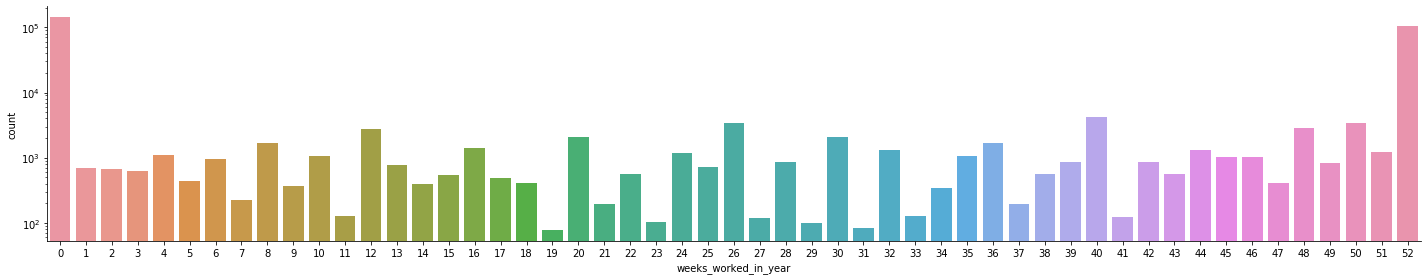

In [9]:
# show dataset's occurence frequency of number of weeks worked in year
g = sns.catplot('weeks_worked_in_year', data=df_analysis, kind="count", height=4, aspect=5)
g.set(yscale="log")

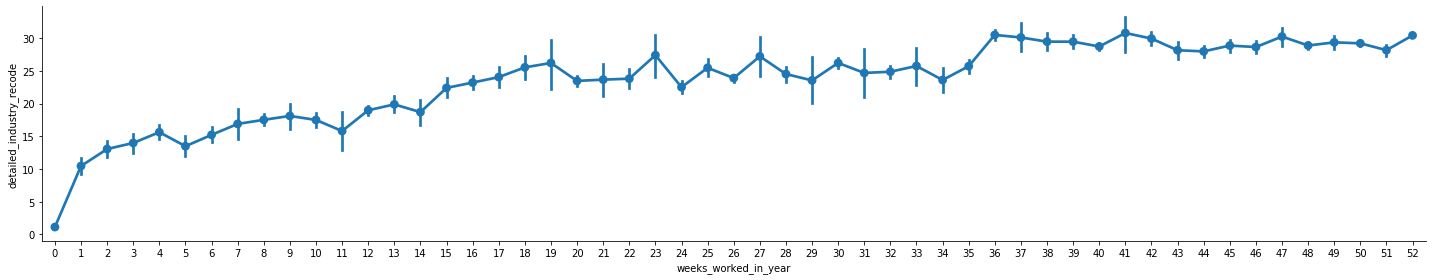

In [10]:
# show relationship/association of two selected features with found signifficant mutual correlation
sns.factorplot(x='weeks_worked_in_year', y='detailed_industry_recode',data=df_analysis, kind="point", height=4, aspect=5)

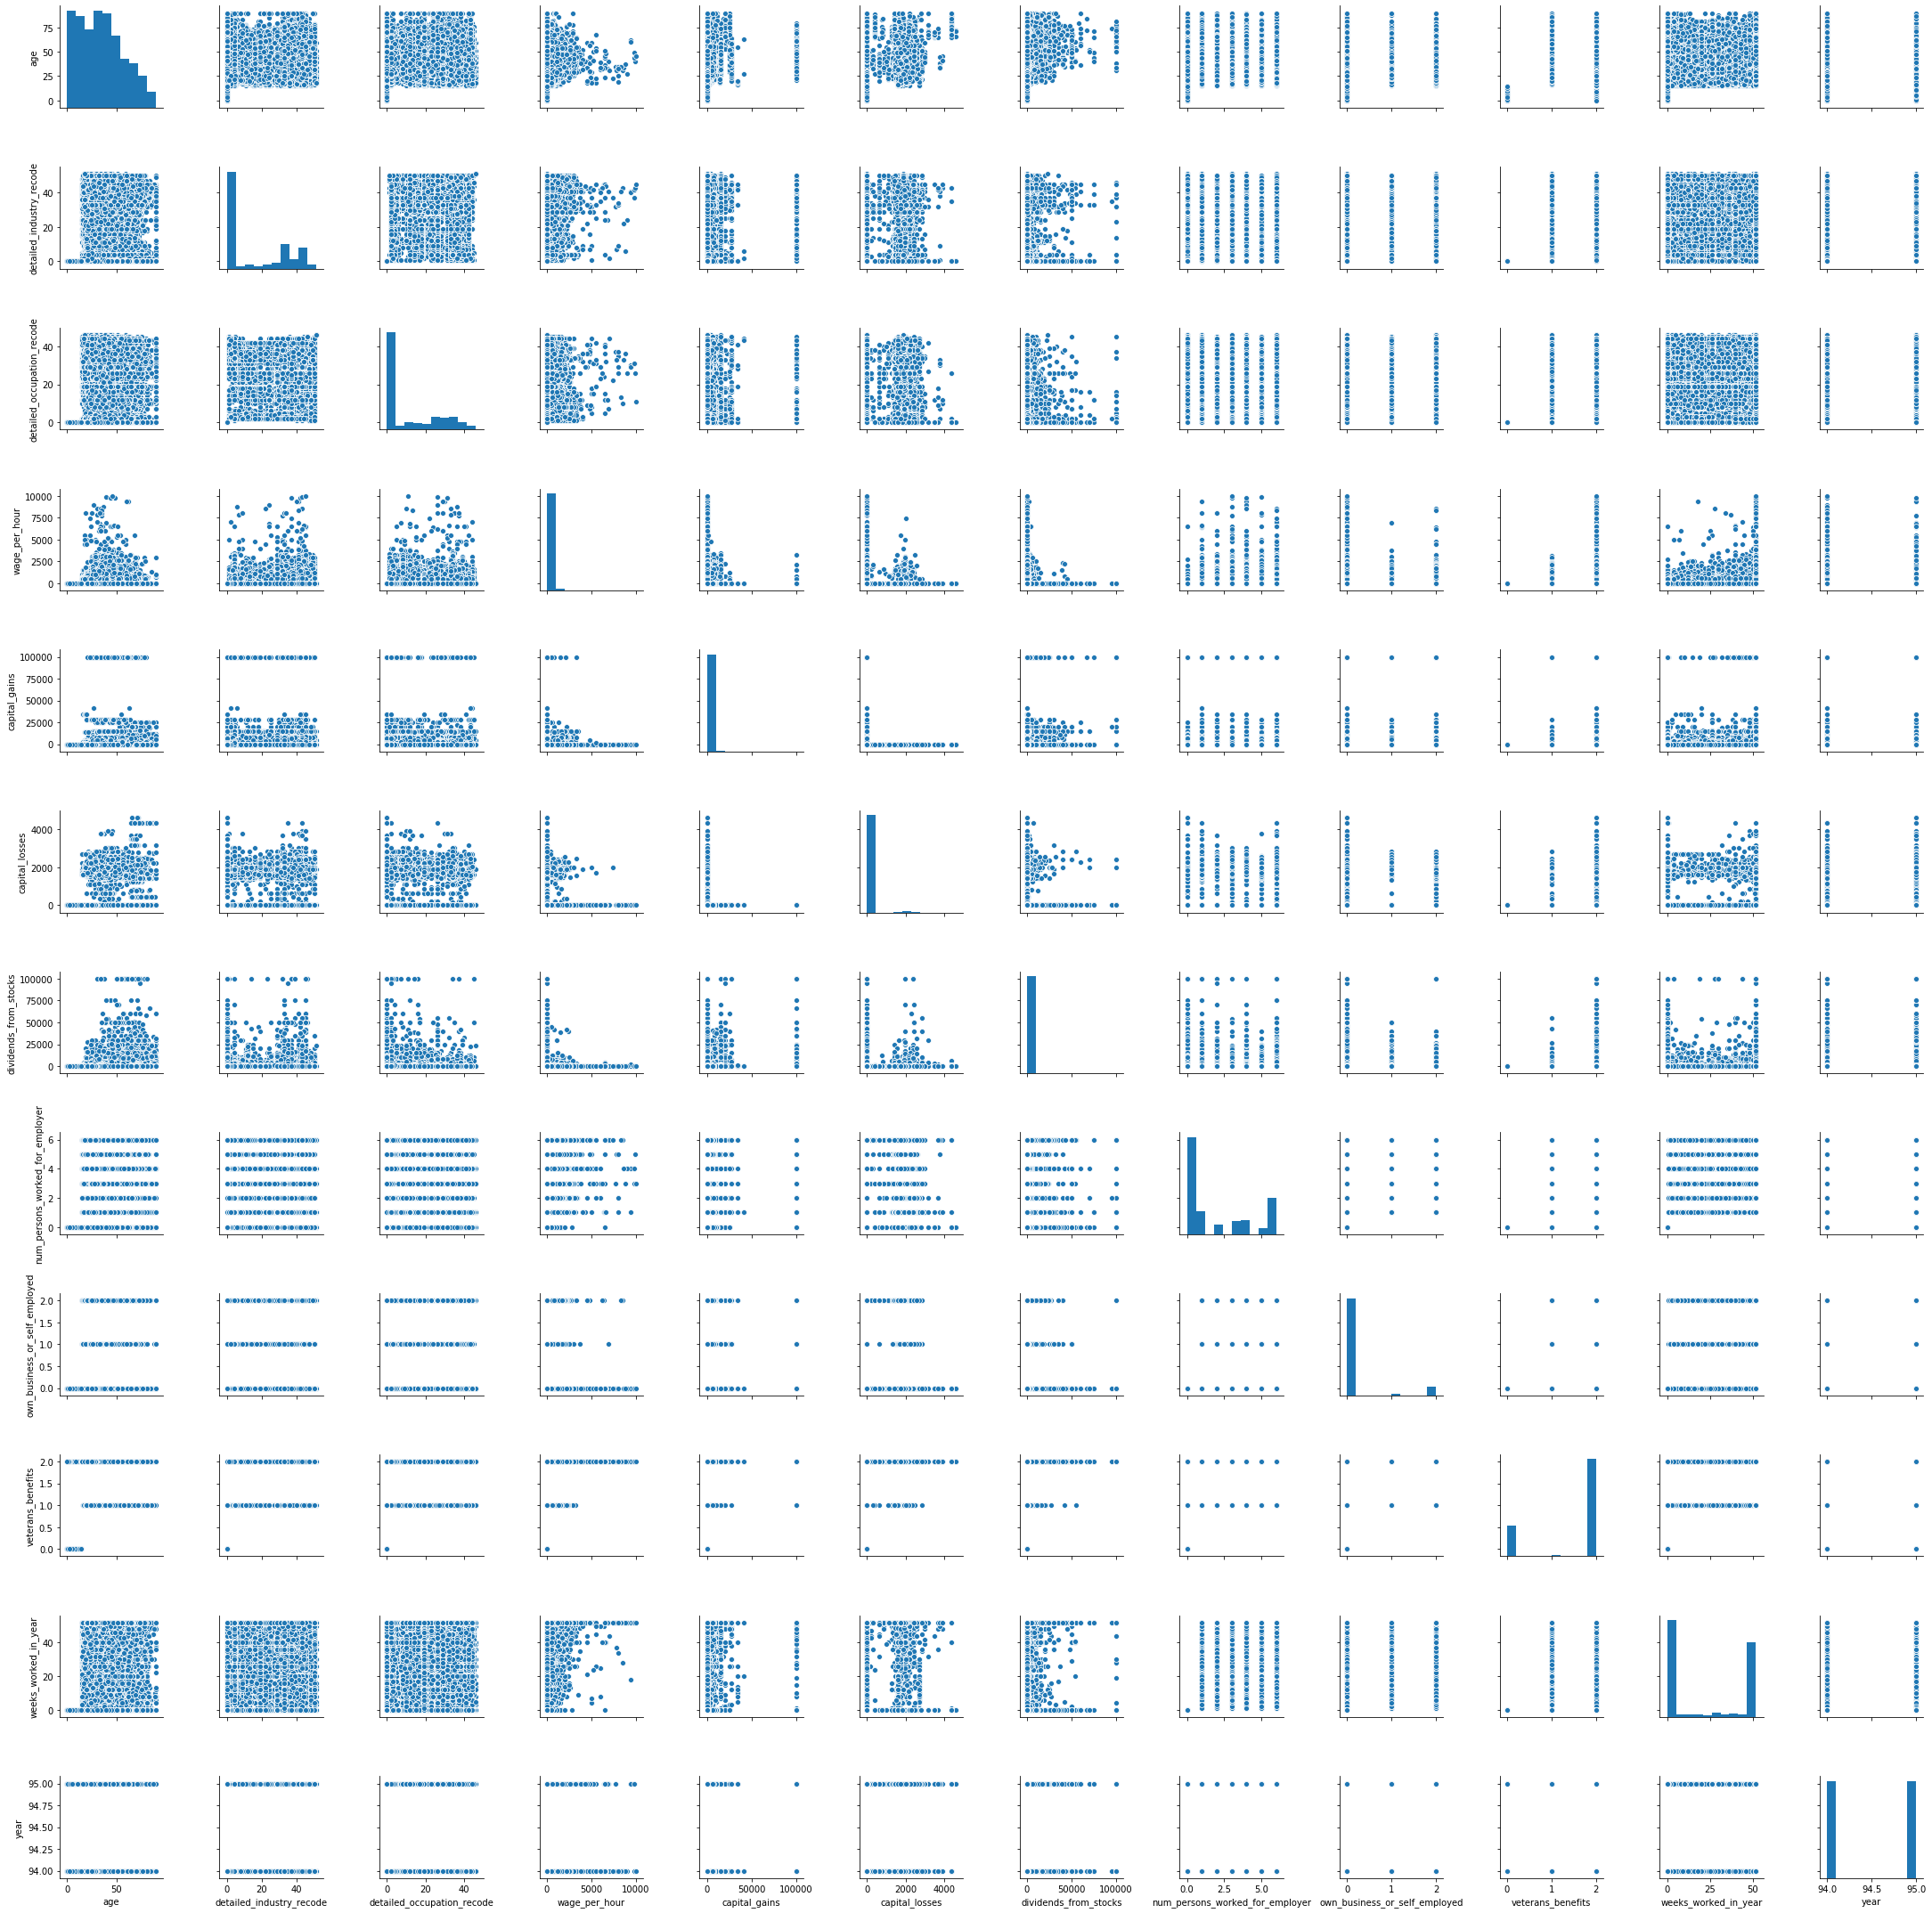

In [45]:
# get glimpse of some associations
sns.pairplot(X_train)

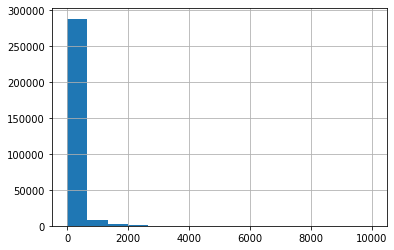

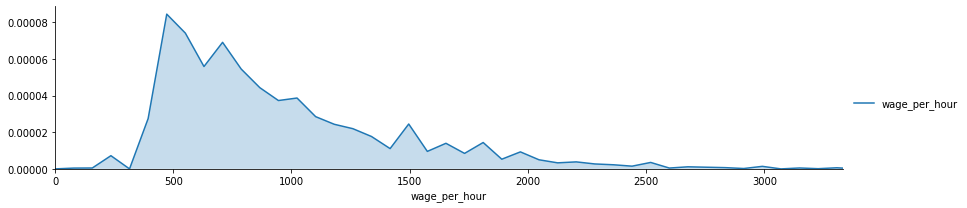

In [21]:
# show histogram of wage_per_hour
df_analysis['wage_per_hour'].hist(bins=15)

# show density of wage_per_hour
fig = sns.FacetGrid(df_analysis, aspect=4)
fig.map(sns.kdeplot, 'wage_per_hour', shade= True)
# adjust  figure
highest_price = df_analysis['wage_per_hour'].max()
fig.set(xlim=(0, highest_price / 3))
fig.add_legend()

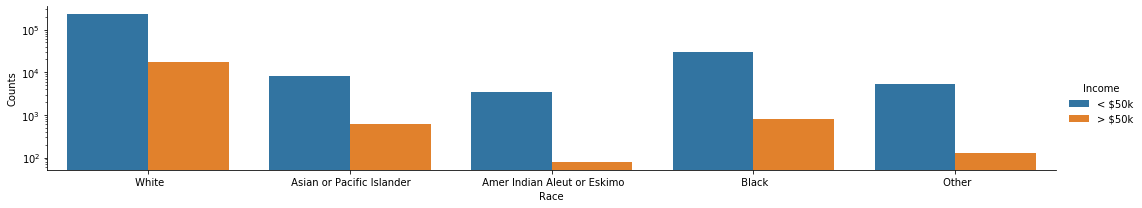

In [22]:
# show proportion of counts of high & low earners vs. race
g = sns.catplot('race',data=df_analysis, hue='Income', kind="count", height=3, aspect=5) 
(g.set(yscale="log") 
  .set_axis_labels("Race", "Counts"))

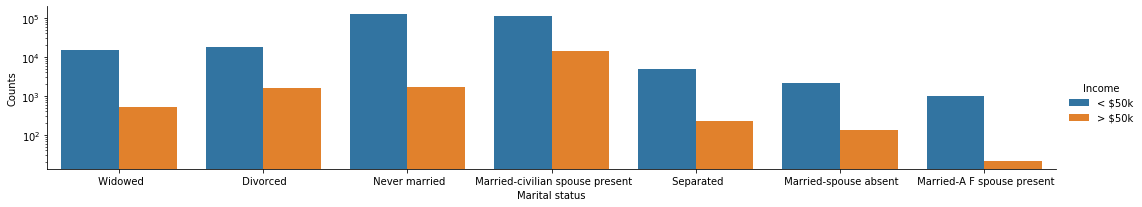

In [23]:
# show proportion of counts of high & low earners against marital status
g = sns.catplot('marital_stat', data=df_analysis, hue='Income', kind="count", height=3, aspect=5) 
(g.set(yscale="log") 
  .set_axis_labels("Marital status", "Counts")) 

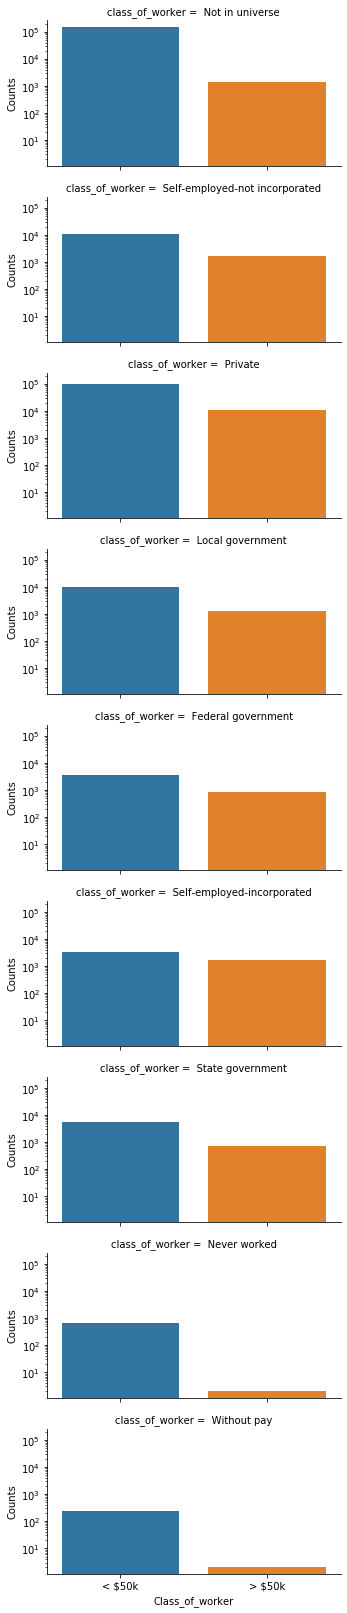

In [24]:
# show proportion of counts of high & low earners vs. occupation class
g = sns.catplot('Income',data=df_analysis, col='class_of_worker', kind="count", 
                dodge=False,col_wrap=1, height=2.5, aspect=2);
(g.set(yscale="log") 
   .set_axis_labels("Class_of_worker", "Counts"))

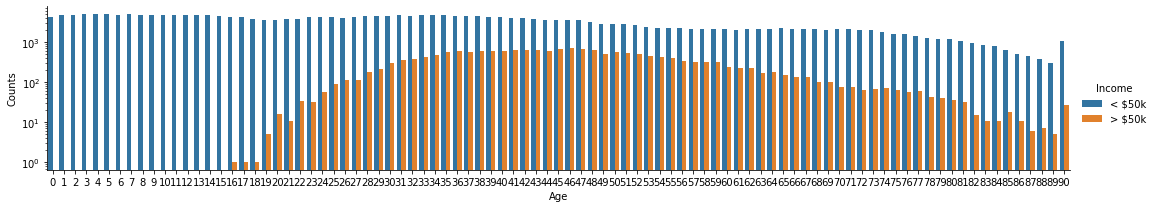

In [25]:
# show proportion of counts of high & low earners per age
g = sns.catplot('age', data=df_analysis, hue='Income', kind="count", height=3, aspect=5) 
(g.set(yscale="log") 
  .set_axis_labels("Age", "Counts"))

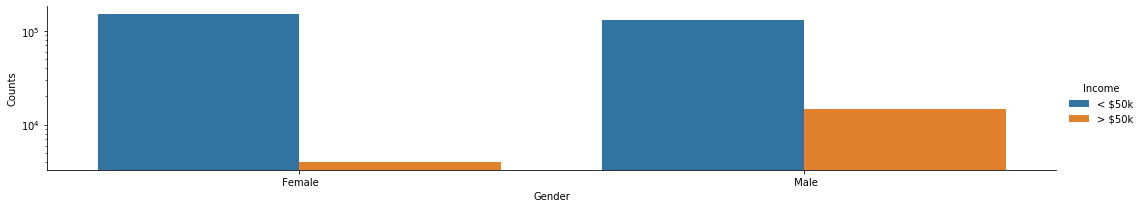

In [26]:
# show proportion of counts of high & low earners on gender
g = sns.catplot('sex', data=df_analysis, hue='Income', kind="count", height=3, aspect=5) 
(g.set(yscale="log") 
  .set_axis_labels("Gender", "Counts"))

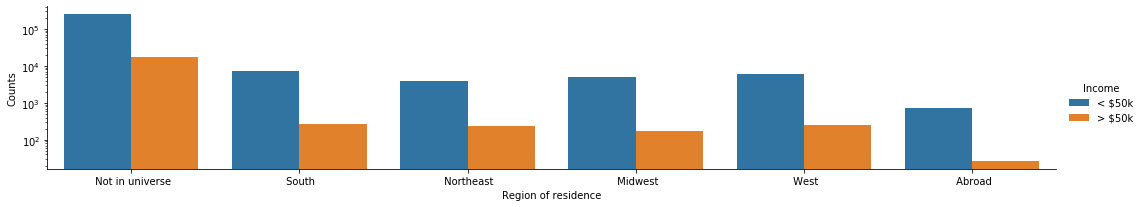

In [27]:
# show proportion of counts of high & low earners vs. US region
g = sns.catplot('region_of_previous_residence', data=df_analysis, hue='Income', kind="count", height=3, aspect=5) 
(g.set(yscale="log") 
  .set_axis_labels("Region of residence", "Counts"))

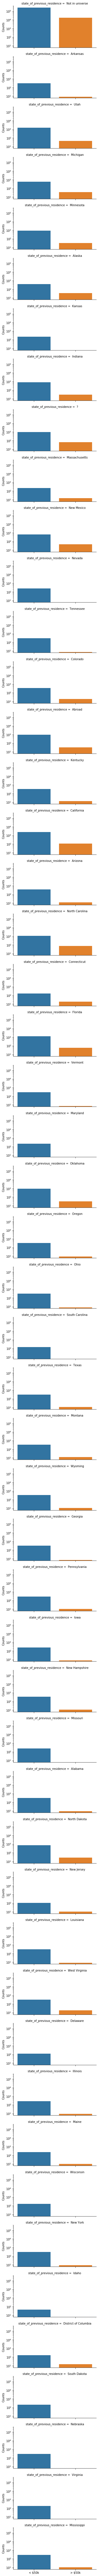

In [28]:
# show proportion of high & low earners vs. US State
g = sns.catplot("Income", 
                col="state_of_previous_residence",
                dodge=False,
                kind="count",
                data=df_analysis,
                col_wrap=1, height=2.5, aspect=2);
g.set(yscale="log");
g.set_axis_labels("", "Counts");


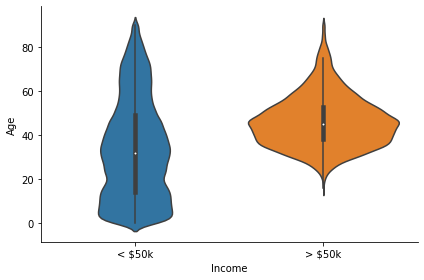

In [29]:
# show dataset's frequency distribution of high & low earners against age

# make violin plot with catplot
g = sns.catplot(x='Income', y='age', kind="violin", data=df_analysis, height=4,aspect=1.5)
# add data points to boxplot with stripplot
#sns.stripplot(x='y', y='age', data=df_analysis, alpha=0.1, jitter=0.2, color='k');
(g.set_axis_labels("Income", "Age"))

<span style='color:blue '>
Observations:
    
- The stats indicate advantageous earning for a white family-man group.
- Strikes a noisy but levelled distribution of frequency of workers per number of worked weeks in year.
- Most frequent wage rate oscillates around 500 USD per hour.
- Corporate and government representatives make relatively better buck than their self-employed colleagues.
- Much smaller percentage of females belongs to the women's "over 50k/yr" club compared to the males pool.
- There are income disproportions between the US States.
- In the lower income cast people up to their 50s can expect to earn uniformly throughout their life, but the higher cast members can expect steady income increase starting at the age of the college graduation and retire early.
- There are correlations between some features without clear cause (signs for potential issues with multicollinearity). Nevertheless I won't inspect it deaper for now.
</span>

## 2. Data Preparation

### 2a) Prediction Missing sub-Labels in Categorical Variables

In [18]:
# predict (for some feature categorical train-set variables) missing values denoted as '?' 

# get categorical col names
df_trained = df_train
categorical = [var for var in df_train.columns if df_train[var].dtype=='O']

# loop over all categorical columns
for feature in tqdm(categorical):
    # make predictions if '?' in column
    if df_trained.loc[df_trained[feature].astype(str) == ' ?', feature].size:
        
        # pick all feature names without the one to be predicted
        columns = [item for item in categorical if item!=feature]
         
        # set train and test data for training 
        train_replace = df_trained[(df_trained[feature].values != ' ?')].copy()
        train_y = train_replace[feature]
        test_replace = df_trained[(df_trained[feature].values == ' ?')].copy()
        
        # save data for later concatenation
        con_train = train_replace
        con_test = test_replace
        
        # remove from data the feature to be predicted 
        train_replace.drop(columns=[feature], inplace=True)
        test_replace.drop(columns=[feature], inplace=True)

        # one-hot encode selected columns 
        encoder = ce.OneHotEncoder(cols=columns)
        train_replace = encoder.fit_transform(train_replace)
        test_replace = encoder.transform(test_replace)
        
        # train and predict category labels instead of '?'
        r_forest = RandomForestClassifier(n_estimators=30) 
        r_forest.fit(train_replace,train_y)
        r_forest_pred = r_forest.predict(test_replace)
        r_forest_pred = list(r_forest_pred)
        
        # incorporate predictions into data 
        location = df_train.columns.get_loc(feature)   
        con_test.insert(loc=location, column=feature, value=r_forest_pred)
        df_trained = pd.concat([con_test, con_train], axis=0)

# save results for further model build
df_train_trained = df_trained     



  0%|          | 0/29 [00:00<?, ?it/s]

 17%|█▋        | 5/29 [00:00<00:00, 46.59it/s]

 34%|███▍      | 10/29 [00:00<00:00, 47.50it/s]

 34%|███▍      | 10/29 [00:12<00:00, 47.50it/s]

 52%|█████▏    | 15/29 [00:50<00:42,  3.03s/it]

 62%|██████▏   | 18/29 [01:24<01:00,  5.53s/it]

 66%|██████▌   | 19/29 [01:55<02:11, 13.17s/it]

 69%|██████▉   | 20/29 [02:27<02:50, 18.95s/it]

 76%|███████▌  | 22/29 [02:59<02:05, 17.93s/it]

 83%|████████▎ | 24/29 [04:04<01:51, 22.39s/it]

 86%|████████▌ | 25/29 [05:38<02:55, 43.83s/it]

100%|██████████| 29/29 [06:51<00:00, 14.20s/it]


In [33]:
# test against remaining missing values in train dataset after predicting all '?'
print('Col:', feature + ",", 'Missing values:', df_trained.loc[df_trained[feature].astype(str) == ' ?', feature].size)

Col: salary, Missing values: 0


In [23]:
# do same as in cell above but for test dataset

df_trained = df_test
for feature in categorical: 
    if df_trained.loc[df_trained[feature].astype(str) == ' ?', feature].size:
        
        columns = [item for item in categorical if item!=feature]    

        train_replace = df_trained[(df_trained[feature].values != ' ?')].copy()
        train_y = train_replace[feature]
        test_replace = df_trained[(df_trained[feature].values == ' ?')].copy()

        con_train = train_replace
        con_test = test_replace

        train_replace.drop(columns=[feature], inplace=True)
        test_replace.drop(columns=[feature], inplace=True)

        encoder = ce.OneHotEncoder(cols=columns)
        train_replace = encoder.fit_transform(train_replace)
        test_replace = encoder.transform(test_replace)

        r_forest = RandomForestClassifier(n_estimators=30) 
        r_forest.fit(train_replace,train_y)
        r_forest_pred = r_forest.predict(test_replace)
        r_forest_pred = list(r_forest_pred)
        
        location = df_test.columns.get_loc(feature)   
        con_test.insert(loc=location, column=feature, value=r_forest_pred)
        df_trained = pd.concat([con_test, con_train], axis=0)

df_test_trained = df_trained          

In [35]:
# test against remaining missing values in test dataset after predicting all '?'
print('Col:', feature + ",", 'Missing values:', df_trained.loc[df_trained[feature].astype(str) == ' ?', feature].size)

Col: salary, Missing values: 0


In [36]:
# get datasets shapes 
df_train_trained.shape, df_test_trained.shape

((199523, 41), (99762, 41))

In [43]:
# check for signs of Pearson's correlation (despite unlikely conditions)
corr = df_train_trained.drop(categorical, axis=1).corr()
corr

,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,y
age,1.000000,0.157822,0.117414,0.036938,0.053590,0.063351,0.104976,0.140887,-0.002265,0.674844,0.206181,0.004413,0.135720
detailed_industry_recode,0.157822,1.000000,0.563493,0.165980,0.066017,0.072586,0.012774,0.642096,0.252694,0.476475,0.754472,0.003430,0.196190
detailed_occupation_recode,0.117414,0.563493,1.000000,0.194498,0.002534,0.043680,-0.026726,0.515554,0.228952,0.438680,0.655613,-0.003140,0.013414
wage_per_hour,0.036938,0.165980,0.194498,1.000000,-0.001082,0.010993,-0.005731,0.191543,0.054051,0.113094,0.195687,0.002283,0.024528
capital_gains,0.053590,0.066017,0.002534,-0.001082,1.000000,-0.012700,0.131476,0.058015,0.015048,0.051530,0.083549,0.005243,0.240725
capital_losses,0.063351,0.072586,0.043680,0.010993,-0.012700,1.000000,0.042427,0.084255,0.024116,0.075391,0.100762,0.000096,0.147417
dividends_from_stocks,0.104976,0.012774,-0.026726,-0.005731,0.131476,0.042427,1.000000,0.007206,-0.004885,0.054585,0.013823,0.001913,0.175779
num_persons_worked_for_employer,0.140887,0.642096,0.515554,0.191543,0.058015,0.084255,0.007206,1.000000,0.240553,0.463334,0.747302,0.018774,0.222684
own_business_or_self_employed,-0.002265,0.252694,0.228952,0.054051,0.015048,0.024116,-0.004885,0.240553,1.000000,0.177448,0.265872,0.007377,0.040473
veterans_benefits,0.674844,0.476475,0.438680,0.113094,0.051530,0.075391,0.054585,0.463334,0.177448,1.000000,0.532279,0.003122,0.140930


In [44]:
# check Spearman's correlation for the selected pair feature-label (weeks_worked_in_year-y)
from scipy.stats import spearmanr
data1 = df_test_trained['y'] 
data2 = df_test_trained['weeks_worked_in_year']
coef, p = spearmanr(data1, data2)
print('Spearmans correlation coefficient: %.3f' % coef)
print('Spearmans correlation p-value: %.3f' % p)

Spearmans correlation coefficient: 0.262
Spearmans correlation p-value: 0.000


<span style='color:blue'>
The correlation coef. is low (it seems statistically significant).
</span>

In [109]:
# get syntax of target class names
df_test_trained.loc[20,'salary']

' - 50000.'

In [110]:
df_test_trained.loc[19,'salary']

' 50000+.'

In [24]:
# assign target class labels as numeric for train/test datasets
df_train_trained.loc[df_train['salary'].astype(str) == ' 50000+.', 'y'] = 1
df_train_trained.loc[df_train['salary'].astype(str) == ' - 50000.', 'y'] = 0
print('Train set class balance:\n', df_train_trained['salary'].value_counts())

df_test_trained.loc[df_test['salary'].astype(str) == ' 50000+.', 'y'] = 1
df_test_trained.loc[df_test['salary'].astype(str) == ' - 50000.', 'y'] = 0
print('Test set class balance:\n', df_test_trained['salary'].value_counts())

# prepare train/test data for model training
X_train = df_train_trained.drop(['salary', 'y'], axis=1)
y_train = df_train_trained['y']

X_test = df_test_trained.drop(['salary', 'y'], axis=1)
y_test = df_test_trained['y']

Train set class balance:
  - 50000.    187141
 50000+.      12382
Name: salary, dtype: int64
Test set class balance:
  - 50000.    93576
 50000+.      6186
Name: salary, dtype: int64


In [42]:
# check created datasets shapes
print(df_train.shape)
print(df_train_trained.shape)
print(X_train.shape)

(199523, 41)
(199523, 42)
(199523, 40)


### 2c) One-Hot Encoding

In [25]:
# one-hot encode categorical data
updated_categorical = [var for var in X_train.columns if X_train[var].dtype=='O']
encoder = ce.OneHotEncoder(cols=updated_categorical)

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# look-up for the shapes
X_train.shape, X_test.shape

((199523, 359), (99762, 359))

### 2d) Scaling Data

In [40]:
# show numerical features
numeric = [var for var in df_train.columns if df_train[var].dtype!='O']
print('There are: ' + str(len(numeric)) + ' attributes')
df_train[numeric]

There are: 12 attributes


,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
0,73,0,0,0,0,0,0,0,0,2,0,95
1,58,4,34,0,0,0,0,1,0,2,52,94
2,18,0,0,0,0,0,0,0,0,2,0,95
3,9,0,0,0,0,0,0,0,0,0,0,94
4,10,0,0,0,0,0,0,0,0,0,0,94
...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,0,0,0,0,0,0,0,0,2,0,95
199519,65,37,2,0,6418,0,9,1,0,2,52,94
199520,47,0,0,0,0,0,157,6,0,2,52,95
199521,16,0,0,0,0,0,0,0,0,2,0,95


In [26]:
# scale all-numeric data with RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

cols = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

# show train data after scaling
X_train.head()

,age,class_of_worker_1,class_of_worker_2,class_of_worker_3,class_of_worker_4,class_of_worker_5,class_of_worker_6,class_of_worker_7,class_of_worker_8,class_of_worker_9,...,citizenship_3,citizenship_4,citizenship_5,own_business_or_self_employed,fill_inc_questionnaire_for_veteran_1,fill_inc_questionnaire_for_veteran_2,fill_inc_questionnaire_for_veteran_3,veterans_benefits,weeks_worked_in_year,year
0,-0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.153846,1.0
1,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-2.0,-0.153846,1.0
2,1.485714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.153846,1.0
3,-0.057143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.153846,1.0
4,1.628571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.153846,1.0


## 3. Data Modeling

<span style='color:red'>
Since the goal is to showcase (not deploy), only three models are selected for manual testing: 
1) Gaussian Naïve Bayes
2) Random Forest and
3) XGB.
</span>

### 3a) Build Gaussian Naïve Bayes as Baseline/Reference Model

In [58]:
# train Gaussian Naïve Bayes baseline classifier on training set
from sklearn.naive_bayes import GaussianNB

# instantiate the model
gNB = GaussianNB()

# fit the model and make predictions
gNB.fit(X_train, y_train)
y_pred_NB = gNB.predict(X_test)

# extra predictions for Traning set
y_pred_train_NB = gNB.predict(X_train)

# get accuracy scores for model as well as for train data 
print('Gaussian Naive Bayes model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_NB)))
print('Training set score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train_NB)))

Gaussian Naive Bayes model accuracy score: 0.7201
Training set score: 0.6973


In [49]:
# sanity check with null accuracy test on dataset
print(y_test.value_counts())
null_acc = 93576 / (6186 + 93576)
print('Null accuracy score: {0:0.4f}'. format(null_acc))

0.0    93576
1.0     6186
Name: y, dtype: int64
Null accuracy score: 0.9380


### 3b) Build Random Forest (RF) Model

In [50]:
# train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rnd_forest = RandomForestClassifier(n_estimators=30) 
rnd_forest.fit(X_train, y_train)
y_pred_rnd_forest = rnd_forest.predict(X_test)

# extra predictions for Traning set
y_pred_train_rnd_forest = rnd_forest.predict(X_train)

# get accuracy scores for the model and train dataset
print('Random Forest model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_rnd_forest)))
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train_rnd_forest)))

Random Forest model accuracy score: 0.9520
Training-set accuracy score: 0.9987


<span style='color:red'>
Comment:
    
RF model overfits the training set!
</span>

### 3c) Optimize Random Forest Model with Grid Search

In [51]:
# address overfitting and train Random Forest with grid search to optimize hyperparameters
from sklearn.model_selection import RandomizedSearchCV

rnd_forest_opt = RandomForestClassifier(n_estimators=30)
params_dist = dict({'max_depth': np.arange(1,30), 'max_features': np.arange(1,41)})

model_grid = RandomizedSearchCV(rnd_forest_opt, params_dist, cv=10, n_jobs=-1, n_iter=20, random_state=1, return_train_score = True)
model_grid.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=30,
                                                    n_jobs=None,
 

In [52]:
# get hyperparametrs for robust model
model_grid.best_params_

{'max_features': 38, 'max_depth': 20}

In [53]:
# train model again with optimized hyperparameters
model_opt = RandomForestClassifier(max_features=38, max_depth=20, random_state=1)
model_opt.fit(X_train,y_train)

y_pred_rnd_forest = model_opt.predict(X_test)

# extra predictions for Traning set
y_pred_train_rnd_forest = model_opt.predict(X_train)

# get accuracy scores for the model and train dataset 
print('Random Forest optimized_model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_rnd_forest)))
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train_rnd_forest)))

Random Forest optimized_model accuracy score: 0.9545
Training-set accuracy score: 0.9729


### 3a) Train Stochastic Xtreme Gradient Boosting (XGB) Classifier

In [28]:
# train XGBoost Classifier
from xgboost import XGBClassifier
xgb_opt = XGBClassifier(n_estimators=30, booster='gbtree')
xgb_opt.fit(X_train, y_train)

y_pred_xgb = xgb_opt.predict(X_test)

# extra predictions for Traning set
y_pred_train_xgb = xgb_opt.predict(X_train)

# get accuracy scores for the model and train dataset
print('Xtreme Gradient Boosting model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_xgb)))
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train_xgb)))

[15:51:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xtreme Gradient Boosting model accuracy score: 0.9565
Training-set accuracy score: 0.9592


<span style='color:blue'>
    Conclusion of Models Training and Params Tweaking:
   
- The baseline model underperforms (below null accuracy).
- Random Forest after selecting optimum hyperparameters reaches 95.45% accuracy, but exhibits a bit of overfitting.
- XGB model has 95.7% accuracy and does quite well on ovefitting, it seems most robust. 
</span>

## 4 Model Assesment

### 4a) Further Performance Comparison for Best Models

In [119]:
# look up model performance standard metrics
from sklearn.metrics import classification_report

# XGB model performance
print('XGB model performance:\n')
print(classification_report(y_test, y_pred_xgb))

print('\nRandom Forest model performance:\n')
# Random Forest model performance
print(classification_report(y_test, y_pred_rnd_forest))

XGB model performance:

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     93576
         1.0       0.75      0.46      0.57      6186

    accuracy                           0.96     99762
   macro avg       0.86      0.72      0.77     99762
weighted avg       0.95      0.96      0.95     99762


Random Forest model performance:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     93576
         1.0       0.74      0.41      0.53      6186

    accuracy                           0.95     99762
   macro avg       0.85      0.70      0.75     99762
weighted avg       0.95      0.95      0.95     99762



### 4b) Confusion Matrix Look-up

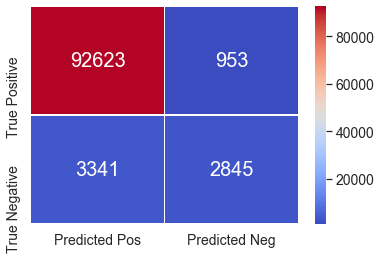

In [131]:
# draw confusion matrix for XGB model
from sklearn.metrics import confusion_matrix

# get confusion matrix
confusion = confusion_matrix(y_test, y_pred_xgb) #y_pred_xgb y_pred_rnd_forest)
conf_matrx = pd.DataFrame(data=confusion, columns=['Predicted Pos', 'Predicted Neg'], 
             index=['True Positive', 'True Negative'])

# set figure parameters
rc = {'font.size': 8, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
fig, ax = plt.subplots(figsize=(6, 4))
kws = {"fontsize":20, "ha": 'center',"va": 'center'}

sns.set(rc=rc)
# plot matrix 
with sns.axes_style('white'):
    sns.heatmap(conf_matrx, annot=True, fmt='d', cmap='coolwarm' , annot_kws=kws, linewidths=.5)  # cmap='coolwarm' 'YlGnBu'

Classification accuracy : 0.9570
Classification error : 0.0430
Precision : 0.9898
Recall/True Positive Rate/Sensitivity : 0.9652
False Positive Rate/(1 - Specificity) : 0.2509
Specificity/True Negative rate : 0.7491


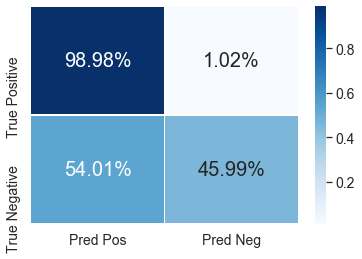

In [132]:
# present matrix's outcome as proportions and print performance metrics

# get modeling results
TP = confusion[0,0]#   ->  True Positive
TN = confusion[1,1]#   ->  True Negative
FP = confusion[0,1]#   ->  False Positive
FN = confusion[1,0]#   ->  False Negative

# compute preditions as proportion of aggregated actual labels 
confusion = confusion. astype(float)
confusion[0,0] = TP / float(TP + FP) 
confusion[1,1] = TN / float(TN + FN) 
confusion[0,1] = FP / float(FP + TP)
confusion[1,0] = FN / float(FN + TN)

conf_matrx = pd.DataFrame(data=confusion, columns=[ 'Pred Pos', 'Pred Neg'], 
             index=['True Positive', 'True Negative'])
rc = {'font.size': 8, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
# Set Figure
fig, ax = plt.subplots(figsize=(6, 4))
kws = {"fontsize":20, "ha": 'center',"va": 'center'}
sns.set(rc=rc)
with sns.axes_style('white'):
    sns.heatmap(conf_matrx, annot=True, fmt='.2%', cmap="Blues", annot_kws= kws, linewidths=.5)

# print classification accuracy
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error : {0:0.4f}'.format(classification_error))

# print precision 
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))

# print recall 
recall = TP / float(TP + FN)
print('Recall/True Positive Rate/Sensitivity : {0:0.4f}'.format(recall))

# print false_positive_rate
false_positive_rate = FP / float(FP + TN)
print('False Positive Rate/(1 - Specificity) : {0:0.4f}'.format(false_positive_rate))

# print specificity
specificity = TN / (TN + FP)
print('Specificity/True Negative rate : {0:0.4f}'.format(specificity))

### 4c) Model Selection

<span style='color:blue'>

Both models (RF & XGB) have comparable accuracy and precision metrics (and for both the weighted f1-score is of 0.95), though XGB has higher True Negative Count  by ~ 5% (in regard to all-negatives) - and related to income over $50k. Due to the imbalance class problem the TN is at a 46% level. A concept of how to tackle this will be discussed in the final results/conclusion.\
</span>

<span style='color:red'>I conclude that the XGB is the best performing model among the considered ones.</span>

### 4d) Receiver Operating Characteristic Curve (ROC) for XBG model

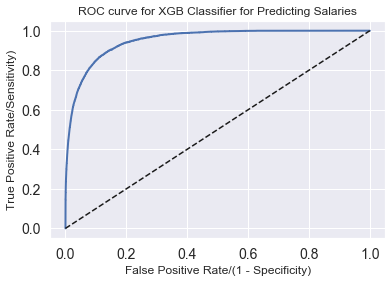

In [66]:
# plot Receiver Operating Characteristic curve (ROC)
from sklearn.metrics import roc_curve

# get predicted probabilities for label 1 
y_pred_1 = xgb_opt.predict_proba(X_test)[:, 1]

# compute Tru/False Positive Rates
FPR, TPR, thresholds = roc_curve(y_test, y_pred_1, pos_label = 1)

# set figure params and plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(FPR, TPR, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for XGB Classifier for Predicting Salaries')
plt.xlabel('False Positive Rate/(1 - Specificity)')
plt.ylabel('True Positive Rate/Sensitivity)')
plt.show()

### 4e) Area Below ROC Curve (ROC AUC) 

In [61]:
# compute area below the curve (ROC AUC)
ROC_AUC = roc_auc_score(y_test, y_pred_1)

# print result for ROC AUC 
print('ROC AUC : {:.4f}'.format(ROC_AUC))

# calculate cross-validated ROC AUC 
Cross_validated_ROC_AUC = cross_val_score(xgb_opt, X_train, y_train, cv=5, scoring='roc_auc').mean()

# print result for cross-validated ROC AUC 
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC)

ROC AUC : 0.9517
[11:31:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used w

In [ ]:
# (optional) combine train and test datasets for better model performance
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

# train Xtreme Gradient Boosting model on larger dataset 
model_best = XGBClassifier(n_estimators=30, booster='gbtree')
model_best.fit(X, y)
model_best.fit(X, y)

## 5 Final Results and Conclussion

<span style='color:red'>
Conclusion:

- Roughly a 10% of earners make over $50k.
- Selected as the best XGB model gained the accuracy & recall of 0.96 and weighted f-score of 0.95 (ROC AUC - 0.95).
- The XGB model performs at the level of the best models mentioned by authors in the provided data source documentation.
- Specificity of 0.75 most probably comes from imbalance target dataset (at rate 15:1). 
- Playing with k_fold cross-validation procedure did not improve metrics.
- The correlation coefficients between some variables essentially are low (by p-value they seem statistically significant).
- They might be other missing values to clean up, for example "0" years old interpretation can be ambiguous.
</span>

<span style='color:red'>
Outlook & further steps to improvement:


- Trying to remedy the imbalance issue -> a classification method might be robustly trained and consequently perform for a depleted dataset. For example, one could use all 'high-earners' data and a random sample from the 'lower-earner' data to improve balance and check whether this yields better modeling (given the number of observations a classification method might work for reduced data). 
- When it's time for a lenghty battle to improve the model's performance by a fraction of % (e.g for deployment), I'd cross-train many more models in the iteration manner, using e.g. sklearn's Pipeline and ColumnTransformer packages to automate the data processing. Some additional performance improvement might result from testing more hyperparameters and scaling ways. Nonetheless, I've already tried to choose kind of best options (for instance within optional: droping records with missing values or replacing them with the most frequent ones I chose predicting them).
- The explanatory part of the project might go deeper to consider distributions and relationships/associations (multicollinearity issues) in data and their impact on the performance. 
- Enriching data, preprocessing and enginering features (e.g. higher orders of combined features) also could be explored all by using for instance Dataiku's DSS.
- ROC curve may be further inspected as well.
- Neural nets could also be an option to consider despite the dataset size.
</span>